# Chapter 17 - Regression

In the previous chapter we saw several examples of logistic regression, which is based on the assumption that the likelihood of an outcome, expressedin the form of log odds, is a linear function of some quantity (continuous or discrete).

In this chapter we'll look at simple linear regression.

We'll use a 3-parameter model!

## More Snow?

The author believes that less snow falls around his home (Norfolk County) than when he was young.

Get the data!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/2239075.csv', parse_dates=[2])
df.head()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
0,USC00190736,"BLUE HILL COOP, MA US",1967-05-11,0.43,0.0,0.0,57,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00190736,"BLUE HILL COOP, MA US",1967-05-12,0.00,0.0,0.0,58,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00190736,"BLUE HILL COOP, MA US",1967-05-13,0.00,0.0,0.0,64,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00190736,"BLUE HILL COOP, MA US",1967-05-14,0.00,0.0,0.0,67,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00190736,"BLUE HILL COOP, MA US",1967-05-15,0.31,0.0,0.0,49,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The columns we'll use are
- `DATE`: the date of each observation
- `SNOW`: the total snowfall, in inches

In [2]:
# add a column which is just the year
df['YEAR'] = df['DATE'].dt.year

# groupby to add up the total snowfall for each year:
snow = df.groupby('YEAR')['SNOW'].sum()
snow

YEAR
1967     28.6
1968     44.7
1969     99.2
1970     66.8
1971     54.6
1972     68.7
1973     12.5
1974     46.5
1975     61.9
1976     57.7
1977     65.5
1978    100.6
1979     34.4
1980     27.7
1981     54.2
1982     64.1
1983     50.2
1984     56.3
1985     49.7
1986     38.3
1987     89.3
1988     53.5
1989     38.5
1990     52.5
1991     30.7
1992     39.0
1993     80.1
1994     88.7
1995     46.0
1996    124.2
1997     77.1
1998     24.1
1999     56.6
2000     43.7
2001     90.8
2002     61.5
2003    112.0
2004     51.8
2005    110.7
2006     40.6
2007     54.2
2008     59.1
2009     85.8
2010     57.6
2011     82.3
2012     31.1
2013     99.1
2014     80.6
2015    141.1
2016     64.0
2017     68.0
2018     90.4
2019     59.6
2020     12.2
Name: SNOW, dtype: float64

Text(0, 0.5, 'Total Annual Snowfall (inches)')

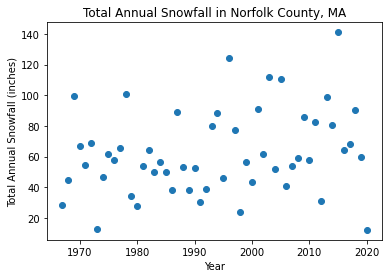

In [3]:
# plot the results:
fig, ax = plt.subplots()
ax.plot(snow.index, snow, 'o')
ax.set_title('Total Annual Snowfall in Norfolk County, MA')
ax.set_xlabel("Year")
ax.set_ylabel("Total Annual Snowfall (inches)")

Just by looking at this, it's hard to say whether the snowfall is increasing, decreasing, or staying the same. Luckily, this kind of noisy question is exactly where Bayesian analysis shines!

## Regression Model

The foundation of any regression model is the assumption that a time series like this is the sum of two parts:
1. A linear function of time, and
1. A series of random values frawn from a distribution that is not changing over time

Mathematically, the regression model is

$$
y = ax + b + \epsilon
$$

Where
- $y$ is the series of measurements (in our case, snowfall)
- $x$ is the series of times (years)
- $\epsilon$ is the series of random values
- $a$ and $b$ are the slope and intercept of the line through the data. They are unknown parameters, so we will use the data to estimate them

We don't know the distribution of $\epsilon$, so we'll additionally make the assumption that it is a normal distribution with mean 0 and and unknown standard deviation, $\sigma$. 

To see whether this assumption is reasonable, I'll plot the distribution of total snowdall and a normal model with the same mean and standard deviation:

In [4]:
from empiricaldist import Pmf

pmf_snowfall = Pmf.from_seq(snow)

mean, std = pmf_snowfall.mean(), pmf_snowfall.std()
mean, std

(62.56851851851851, 27.1357207799914)

<AxesSubplot:>

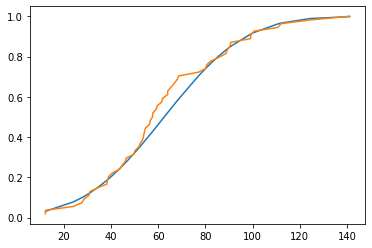

In [5]:
from scipy.stats import norm

dist = norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

plt.plot(qs, ps)
pmf_snowfall.make_cdf().plot()

From this it looks like are a few more slightly below-average years of snowfall, but overall this looks like a good fit.

## Least Squares Regression

Our regression model has three parameters: slope, intercept, and standard deviation of $\epsilon$. To help us choose priors, we'll use `statsmodel` to fit a line to the data by least-squares regression.

In [6]:
# convert snow back to a DataFrame
data = snow.reset_index()
data.head(3)

,YEAR,SNOW
0,1967,28.6
1,1968,44.7
2,1969,99.2


In [7]:
# centre the data by subtracting off the mean
offset = data['YEAR'].mean().round()
data['x'] = data['YEAR'] - offset
offset

1994.0

In [8]:
# add the same column to data so the dependent variable has a standard name:
data['y'] = data['SNOW']

# use statsmodel to compute the least-squares fit:
import statsmodels.formula.api as smf

formula = "y ~ x"
results = smf.ols(formula, data=data).fit()
results.params

Intercept    62.780489
x             0.423941
dtype: float64

These parameters tell us that the snowfall in year 0 (1994) should have been about 64", and that it seems to be increasing at a rate of a little less than half an inch a year.

The variable `results` also provides `resid`, which is an array of residuals - that is, the differences between the data and the fitted line. The standard deviation of the resifuals is an estimate of $\sigma$:

In [9]:
results.resid.std()

26.566114647742996

## Priors

Use uniform priors for each of the parameters:

In [10]:
from utils import make_uniform, make_joint

qs = np.linspace(-0.5, 1.5, 51)
prior_slope = make_uniform(qs, "Slope")

qs = np.linspace(54, 75, 41)
prior_intercept = make_uniform(qs, "Intercept")

qs = np.linspace(20, 35, 31)
prior_sigma = make_uniform(qs, "Sigma")

# creating a function to represent a joint distribution with three parameters:
def make_joint3(pmf1, pmf2, pmf3):
    """ Make a joint distribution with three parameters """
    joint2 = make_joint(pmf2, pmf1).stack()
    joint3 = make_joint(pmf3, joint2).stack()
    return Pmf(joint3)

prior = make_joint3(prior_slope, prior_intercept, prior_sigma)
prior.head(3)

Slope  Intercept  Sigma
-0.5   54.0       20.0     0.000015
                  20.5     0.000015
                  21.0     0.000015
Name: , dtype: float64

Note that the size is getting pretty large - in this case, it is the product of the number of each parameter that we are testing. That means it is $51 * 41 * 31 = 64 821$.

## Likelihood

Now we'll compute the likelihood of the data. To do so, we'll assume that we know the values of the parameters:

In [11]:
inter = 64
slope = 0.51
sigma = 25

xs = data['x']
ys = data['y']

# compute the residuals
expected = slope * xs + inter
resid = ys - expected

According to our model, the residuals should follow a normal distribution with mean $0$ and a standard deviation of $\sigma$. So we can compute the likelihood of each residual value using `norm` from `scipy.stats`:

In [12]:
densities = norm(0, sigma).pdf(resid)

likelihood = densities.prod()
likelihood

8.030916905259667e-111

## The Update

In [13]:
likelihood = prior.copy()

for slope, inter, sigma in prior.index:
    expected = slope * xs + inter
    resid = ys - expected
    densities = norm.pdf(resid, 0, sigma)
    likelihood[slope, inter, sigma] = densities.prod()

This computation takes quite a while - we are approaching the limit of what we can do with a grid approximation!

In [14]:
posterior = prior * likelihood
posterior.normalize()

5.449892039155885e-112

The result is a PMF with a 3-level index: `slope`, `inter`, and `sigma`. We can grab the marginals:

/home/eric/documents/tutorials/ThinkBayes/venv/lib/python3.8/site-packages/empiricaldist/empiricaldist.py:673: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  return Pmf(self.sum(level=i))


<AxesSubplot:xlabel='Sigma'>

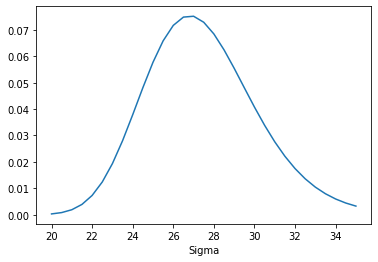

In [15]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

posterior_sigma.plot()

We don't actually care about sigma - we just need to estimate it as part of our model. We show it here for two reasons:
1. Is the location consistent with our expectation? In this case, yes - it roughly matches our previously-calculated sigma
2. Are the probabilities near the edge close to zero? That indicates that we have considered the relevant values of the parameters. In our case, again it looks good.

<AxesSubplot:xlabel='Intercept'>

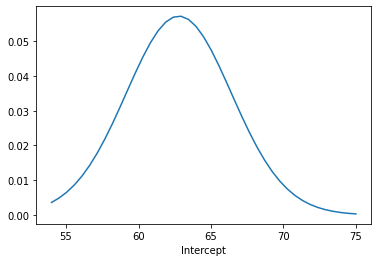

In [16]:
posterior_inter.plot()

<AxesSubplot:xlabel='Slope'>

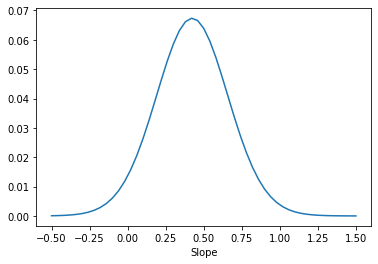

In [17]:
posterior_slope.plot()

In [18]:
posterior_slope.credible_interval(0.9)

array([0.02, 0.82])

This interval is pretty wide. In fact, there is even a non-negligible chance (about 2%) that it is negative.

This is an example of how with noisy data, sometimes your intuition can be wrong!

## Marathon World Record

For many sporting events, the world record pace / time seems to follow a linear trend. Let's consider the world-record time for the male marathon, and try to fit a linear model to estimate when the time will be less than two hours.

In [19]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

5

In [20]:
table = tables[0]
table.head(3)

,Time,Name,Nationality,Date,Event/Place,Source,Notes
0,2:55:18.4,Johnny Hayes,United States,"July 24, 1908","London, United Kingdom",IAAF[53],Time was officially recorded as 2:55:18 2/5.[5...
1,2:52:45.4,Robert Fowler,United States,"January 1, 1909","Yonkers,[nb 5] United States",IAAF[53],Note.[56]
2,2:46:52.8,James Clark,United States,"February 12, 1909","New York City, United States",IAAF[53],Note.[56]


In [21]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date'].head(3)

0   1908-07-24
1   1909-01-01
2   1909-02-12
Name: date, dtype: datetime64[ns]

In [22]:
table['time'] = pd.to_timedelta(table['Time'])
table['time'].head(3)

0   0 days 02:55:18.400000
1   0 days 02:52:45.400000
2   0 days 02:46:52.800000
Name: time, dtype: timedelta64[ns]

In [23]:
# convert the time to pace (miles / hr)
table['y'] = 26.2 / table['time'].dt.total_seconds() * 3600
table['y'].head()

0    8.967143
1    9.099504
2    9.419942
3    9.465508
4    9.672854
Name: y, dtype: float64

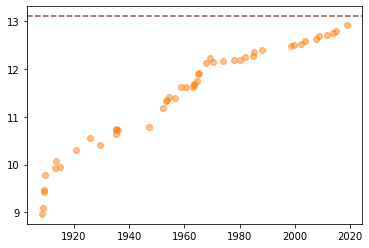

In [24]:
# to plot the speeds
def plot_speeds(df):
    """ Plot the speeds for a marathon time """
    plt.axhline(13.1, color="C5", linestyle="dashed")
    plt.plot(df['date'], df['y'], 'o',
    label="World Record Speed",
    color="C1", alpha=0.5)
    
plot_speeds(table)

In [25]:
# let's just focus on the more recent times:
recent = table['date'] > pd.to_datetime('1970')
data = table.loc[recent].copy()
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh, Scotland",ARRS[9],NaN,1970-07-23,0 days 02:09:28.800000,12.140871
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch, New Zealand",ARRS[9],NaN,1974-01-31,0 days 02:09:12,12.167183
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[9],NaN,1978-02-05,0 days 02:09:05.600000,12.177236
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[9],NaN,1980-04-26,0 days 02:09:01,12.184472
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[53] ARRS[9]",NaN,1981-12-06,0 days 02:08:18,12.252533


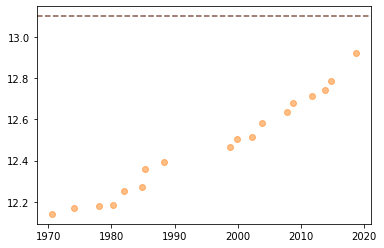

In [26]:
plot_speeds(data)

In [27]:
# prepare the data by subtracting away the midpoint
offset = pd.to_datetime('1995')
timedelta = table['date'] - offset
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24

# again, let's use least squares regression to get estimates for our parameters:
import statsmodels.formula.api as smf

formula = "y ~ x"
results = smf.ols(formula, data=data).fit()
results.params

Intercept    12.460507
x             0.015464
dtype: float64

In [28]:
# again, we can use the std of the residuals as a point estimate for `sigma`
results.resid.std()

0.04139961220193233

## The Priors

Again, let's start with uniform priors for `slope`, `intercept`, and `sigma`

In [29]:
qs = np.linspace(0.012, 0.018, 51)
prior_slope = make_uniform(qs, 'Slope')

qs = np.linspace(12.4, 12.5, 41)
prior_inter = make_uniform(qs, "Intercept")

qs = np.linspace(0.01, 0.21, 31)
prior_sigma = make_uniform(qs, "Sigma")

prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior.head()

Slope  Intercept  Sigma   
0.012  12.4       0.010000    0.000015
                  0.016667    0.000015
                  0.023333    0.000015
Name: , dtype: float64

In [30]:
# Now compute the likelihood as usual
xs = data['x']
ys = data['y']
likelihood = prior.copy()

for slope, inter, sigma in prior.index:
    estimated = inter + slope * xs
    residuals = ys - estimated
    likes = norm.pdf(residuals, 0, sigma)
    likelihood[slope, inter, sigma] = likes.prod()
    
posterior = prior * likelihood
posterior.normalize()

654100803618.6069

In [31]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

/home/eric/documents/tutorials/ThinkBayes/venv/lib/python3.8/site-packages/empiricaldist/empiricaldist.py:673: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  return Pmf(self.sum(level=i))


<AxesSubplot:xlabel='Intercept'>

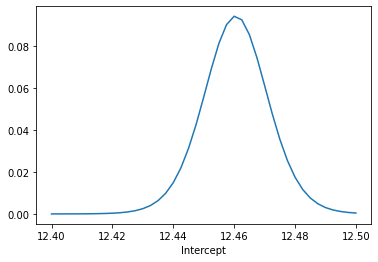

In [32]:
posterior_inter.plot()

<AxesSubplot:xlabel='Slope'>

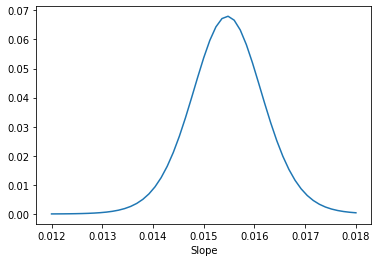

In [33]:
posterior_slope.plot()

## Prediction

To generate the prediction, we'll draw a sample from the posterior distrivution of parameters, the use the regression equation to combine the parameters with the data.

In [34]:
sample = posterior.choice(101)
sample.shape

(101,)

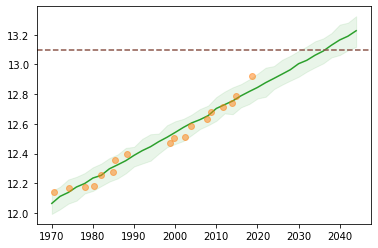

In [35]:
xs = np.arange(-25, 50, 2)
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter, sigma) in enumerate(sample):
    epsilon = norm(0, sigma).rvs(len(xs))
    pred[i] = inter + slope * xs + epsilon
    
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)

times = pd.to_timedelta(xs * 365.24 , unit="days") + offset

plt.fill_between(times, low, high, color="C2", alpha=0.1)
plt.plot(times, median, color="C2")
plot_speeds(data)

Just by eyeballing it, it looks like the record will be broken somewhere between 2030 and 2040. However, we can be more precise by using interpolation!

In [36]:
from scipy.interpolate import interp1d

future = np.array([
    interp1d(high, xs)(13.1),
    interp1d(median, xs)(13.1),
    interp1d(low, xs)(13.1),
])
future + 1995

array([2030.62243959, 2036.47780235, 2042.39178173])

So the 90% credible interval run from early 2031 to early 2043.

## Exercises

### Exercise 17-1

I am under the impression that it is warmer around here than it used to be. In this exercise, you can put the conjecture to the test.

Use the same dataset as for the snow. It also contains the daily high and low temperatures.

1. Use `statsmodels` to generate point estimates for the paramters
1. Choose priors for `slope`, `intercept`, and `sigma` based on these estimates, and use `make_joint3` to make a joint prior distribution
1. Compute the likelihood of the data and compute the posterior distribution of the parameters
1. Extract the posterior distriution of `slope`. How confident are we that temperature is increasing?
1. Draw a sample of paramters from the posterior distribution and use it to generate predictions up to 2067
1. plot the median of the predictions and a 90% credible interval along with the observed data.

Does the model fit the data well? How much do we expect annual average temperature to increase over the author's expected lifetime?

In [41]:
df.head()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,...,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18,YEAR
0,USC00190736,"BLUE HILL COOP, MA US",1967-05-11,0.43,0.0,0.0,57,36.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1967
1,USC00190736,"BLUE HILL COOP, MA US",1967-05-12,0.00,0.0,0.0,58,39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1967
2,USC00190736,"BLUE HILL COOP, MA US",1967-05-13,0.00,0.0,0.0,64,38.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1967
3,USC00190736,"BLUE HILL COOP, MA US",1967-05-14,0.00,0.0,0.0,67,44.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1967
4,USC00190736,"BLUE HILL COOP, MA US",1967-05-15,0.31,0.0,0.0,49,41.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1967


In [42]:
df['TMID'] = (df['TMAX'] + df['TMIN']) / 2

In [44]:
# now group by year and find the mean
tmid = df.groupby('YEAR')['TMID'].mean()
tmid

YEAR
1967    55.325532
1968    48.071038
1969    48.687671
1970    48.258904
1971    48.804110
1972    47.112022
1973    50.479452
1974    48.741096
1975    49.758904
1976    48.360656
1977    48.989041
1978    47.352055
1979    49.368493
1980    47.983607
1981    48.652055
1982    48.017808
1983    49.710959
1984    49.296448
1985    48.597260
1986    48.383562
1987    48.802740
1988    48.989071
1989    48.150685
1990    50.971233
1991    50.853425
1992    47.635246
1993    48.727397
1994    49.382192
1995    49.230137
1996    48.653005
1997    48.942466
1998    51.531507
1999    51.400000
2000    48.467213
2001    50.834247
2002    50.334247
2003    47.979452
2004    48.304645
2005    49.490385
2006    51.305479
2007    49.606849
2008    49.928962
2009    48.704110
2010    51.690411
2011    50.978082
2012    52.351093
2013    50.098630
2014    49.317808
2015    50.019178
2016    51.620219
2017    50.701370
2018    50.235616
2019    49.356164
2020    38.412879
Name: TMID, dtype: floa

In [45]:
# drop the first and last since they are incomplete
complete = tmid.iloc[1:-1]
len(complete)

52

<AxesSubplot:xlabel='YEAR'>

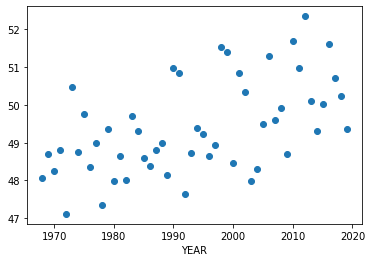

In [48]:
complete.plot(ls="", marker="o")

In [50]:
data = complete.reset_index()
data.head()

,YEAR,TMID
0,1968,48.071038
1,1969,48.687671
2,1970,48.258904
3,1971,48.804110
4,1972,47.112022


In [54]:
offset = data['YEAR'].mean().round()
offset

1994.0

In [55]:
data['x'] = data['YEAR'] - offset
data['y'] = data['TMID']
data.head()

,YEAR,TMID,x,y
0,1968,48.071038,-26.0,48.071038
1,1969,48.687671,-25.0,48.687671
2,1970,48.258904,-24.0,48.258904
3,1971,48.804110,-23.0,48.804110
4,1972,47.112022,-22.0,47.112022


In [79]:
data

,YEAR,TMID,x,y
0,1968,48.071038,-26.0,48.071038
1,1969,48.687671,-25.0,48.687671
2,1970,48.258904,-24.0,48.258904
3,1971,48.804110,-23.0,48.804110
4,1972,47.112022,-22.0,47.112022
5,1973,50.479452,-21.0,50.479452
6,1974,48.741096,-20.0,48.741096
7,1975,49.758904,-19.0,49.758904
8,1976,48.360656,-18.0,48.360656
9,1977,48.989041,-17.0,48.989041


In [58]:
formula = "y ~ x"
results = smf.ols(formula, data=data).fit()
results.params

Intercept    49.430172
x             0.044252
dtype: float64

In [60]:
results.resid.std()

1.041705765390206

In [88]:
# get the priors for the three parameters: intercept, slope, and sigma
qs = np.linspace(48, 52, 51)
prior_intercept = make_uniform(qs, "Intercept")

qs = np.linspace(-0.1, 0.1, 51)
prior_slope = make_uniform(qs, "Slope")

qs = np.linspace(0.5, 2, 51)
prior_sigma = make_uniform(qs, "Sigma")

joint_prior = make_joint3(prior_intercept, prior_slope, prior_sigma)
joint_prior.head()

Intercept  Slope  Sigma
48.0       -0.1   0.50     0.000008
                  0.53     0.000008
                  0.56     0.000008
Name: , dtype: float64

In [89]:
# now compute the likelihood
likelihood = joint_prior.copy()

for intercept, slope, sigma in joint_prior.index:
    estimated = intercept + slope * data['x']
    residuals = data['y'] - estimated
    likes = norm.pdf(residuals, 0, sigma)
    likelihood[intercept, slope, sigma] = likes.prod()

In [90]:
posterior = joint_prior * likelihood
posterior.normalize()

3.2942092664851435e-36

In [91]:
posterior_inter = posterior.marginal(0)
posterior_slope = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

/home/eric/documents/tutorials/ThinkBayes/venv/lib/python3.8/site-packages/empiricaldist/empiricaldist.py:673: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  return Pmf(self.sum(level=i))


<AxesSubplot:xlabel='Intercept'>

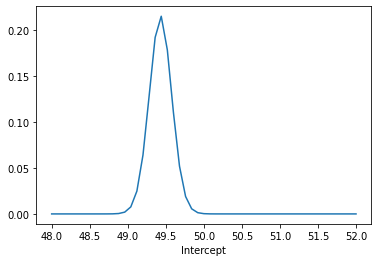

In [92]:
posterior_inter.plot()

<AxesSubplot:xlabel='Slope'>

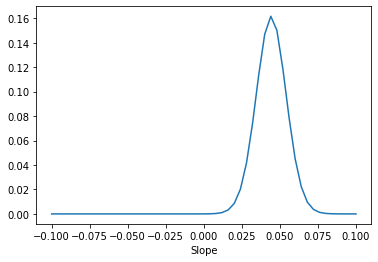

In [93]:
posterior_slope.plot()

<AxesSubplot:xlabel='Sigma'>

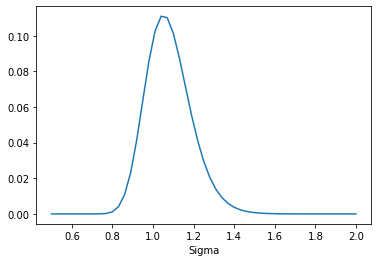

In [94]:
posterior_sigma.plot()

In [95]:
posterior_slope.credible_interval(0.9)

array([0.028, 0.06 ])

In [98]:
posterior_slope.prob_lt(0)

9.60660062641891e-06

So from this is seems pretty unlikely that the temperature is falling!

In [99]:
sample = posterior.choice(101)

years = np.arange(1967, 2067, 2)
xs = years - offset

pred = np.empty((len(sample), len(xs)))

for i, (inter, slope, sigma) in enumerate(sample):
    pred[i] = inter + slope * xs + norm(0, sigma).rvs(len(xs))
    
pred.shape

(101, 50)

In [100]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(50,)

<AxesSubplot:xlabel='YEAR'>

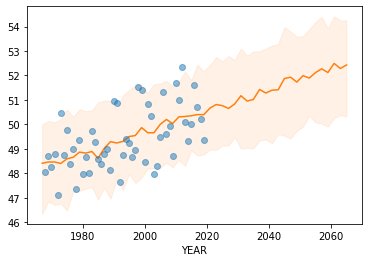

In [101]:
plt.fill_between(years, low, high, color="C1", alpha=0.1)
plt.plot(years, median, color="C1")
complete.plot(ls="", marker="o", alpha=0.5)